In [84]:
# Import necessary libraries
import pandas as pd
import os
import ast
import matplotlib.pyplot as plt
import seaborn as sns

# Function to clean and process citations
def clean_citation(citation):
    return citation.strip().strip("'")

def get_citations(citations_str):
    try:
        citations = ast.literal_eval(citations_str)
        return [clean_citation(citation) for citation in citations]
    except (ValueError, SyntaxError):
        return []

# Paths to the datasets
main_data_path = 'data_stackoverflow.csv'
output_path = './outputs_gemma2_9b'

In [85]:

# Read the main dataset with information on accepted answers
df_main = pd.read_csv(main_data_path)

# Collect all citation.csv files
citations_files = [f'{output_path}/{dir}/citations.csv' for dir in os.listdir(output_path) 
                   if 'citations.csv' in os.listdir(f'{output_path}/{dir}')]

# Initialize a list to store data
data = []

# Read each citation file and append to the data list
for citation_file in citations_files:
    dirname = citation_file.split('/')[2]
    df_temp = pd.read_csv(citation_file)
    if not df_temp.empty:
        citations = get_citations(df_temp['citations'].iloc[0])
        data.append([dirname, citations])

# Create a DataFrame from the collected data
df_citations = pd.DataFrame(data, columns=['dirname', 'citations'])

# Merge main dataset with citations
df_main['dirname'] = df_main['id'].astype(str)
df_merged = pd.merge(df_main, df_citations, on='dirname', how='left')

# Calculate image count for accepted answers and update 'has_image' column
df_merged['accepted_answer_images'] = df_merged['accepted_answer_images'].apply(lambda x: str(x).split(",") if (str(x) != 'nan') else [])
df_merged['image_count'] = df_merged['accepted_answer_images'].apply(lambda x: len(x) if isinstance(x, list) else 0)
df_merged['has_image'] = df_merged['image_count'] > 0

# Add a column to check if there are citations
df_merged['has_citations'] = df_merged['citations'].apply(lambda x: len(x) > 0)

# Calculate citation counts
df_merged['citations_count'] = df_merged['citations'].apply(lambda x: len(x) if isinstance(x, list) else 0)

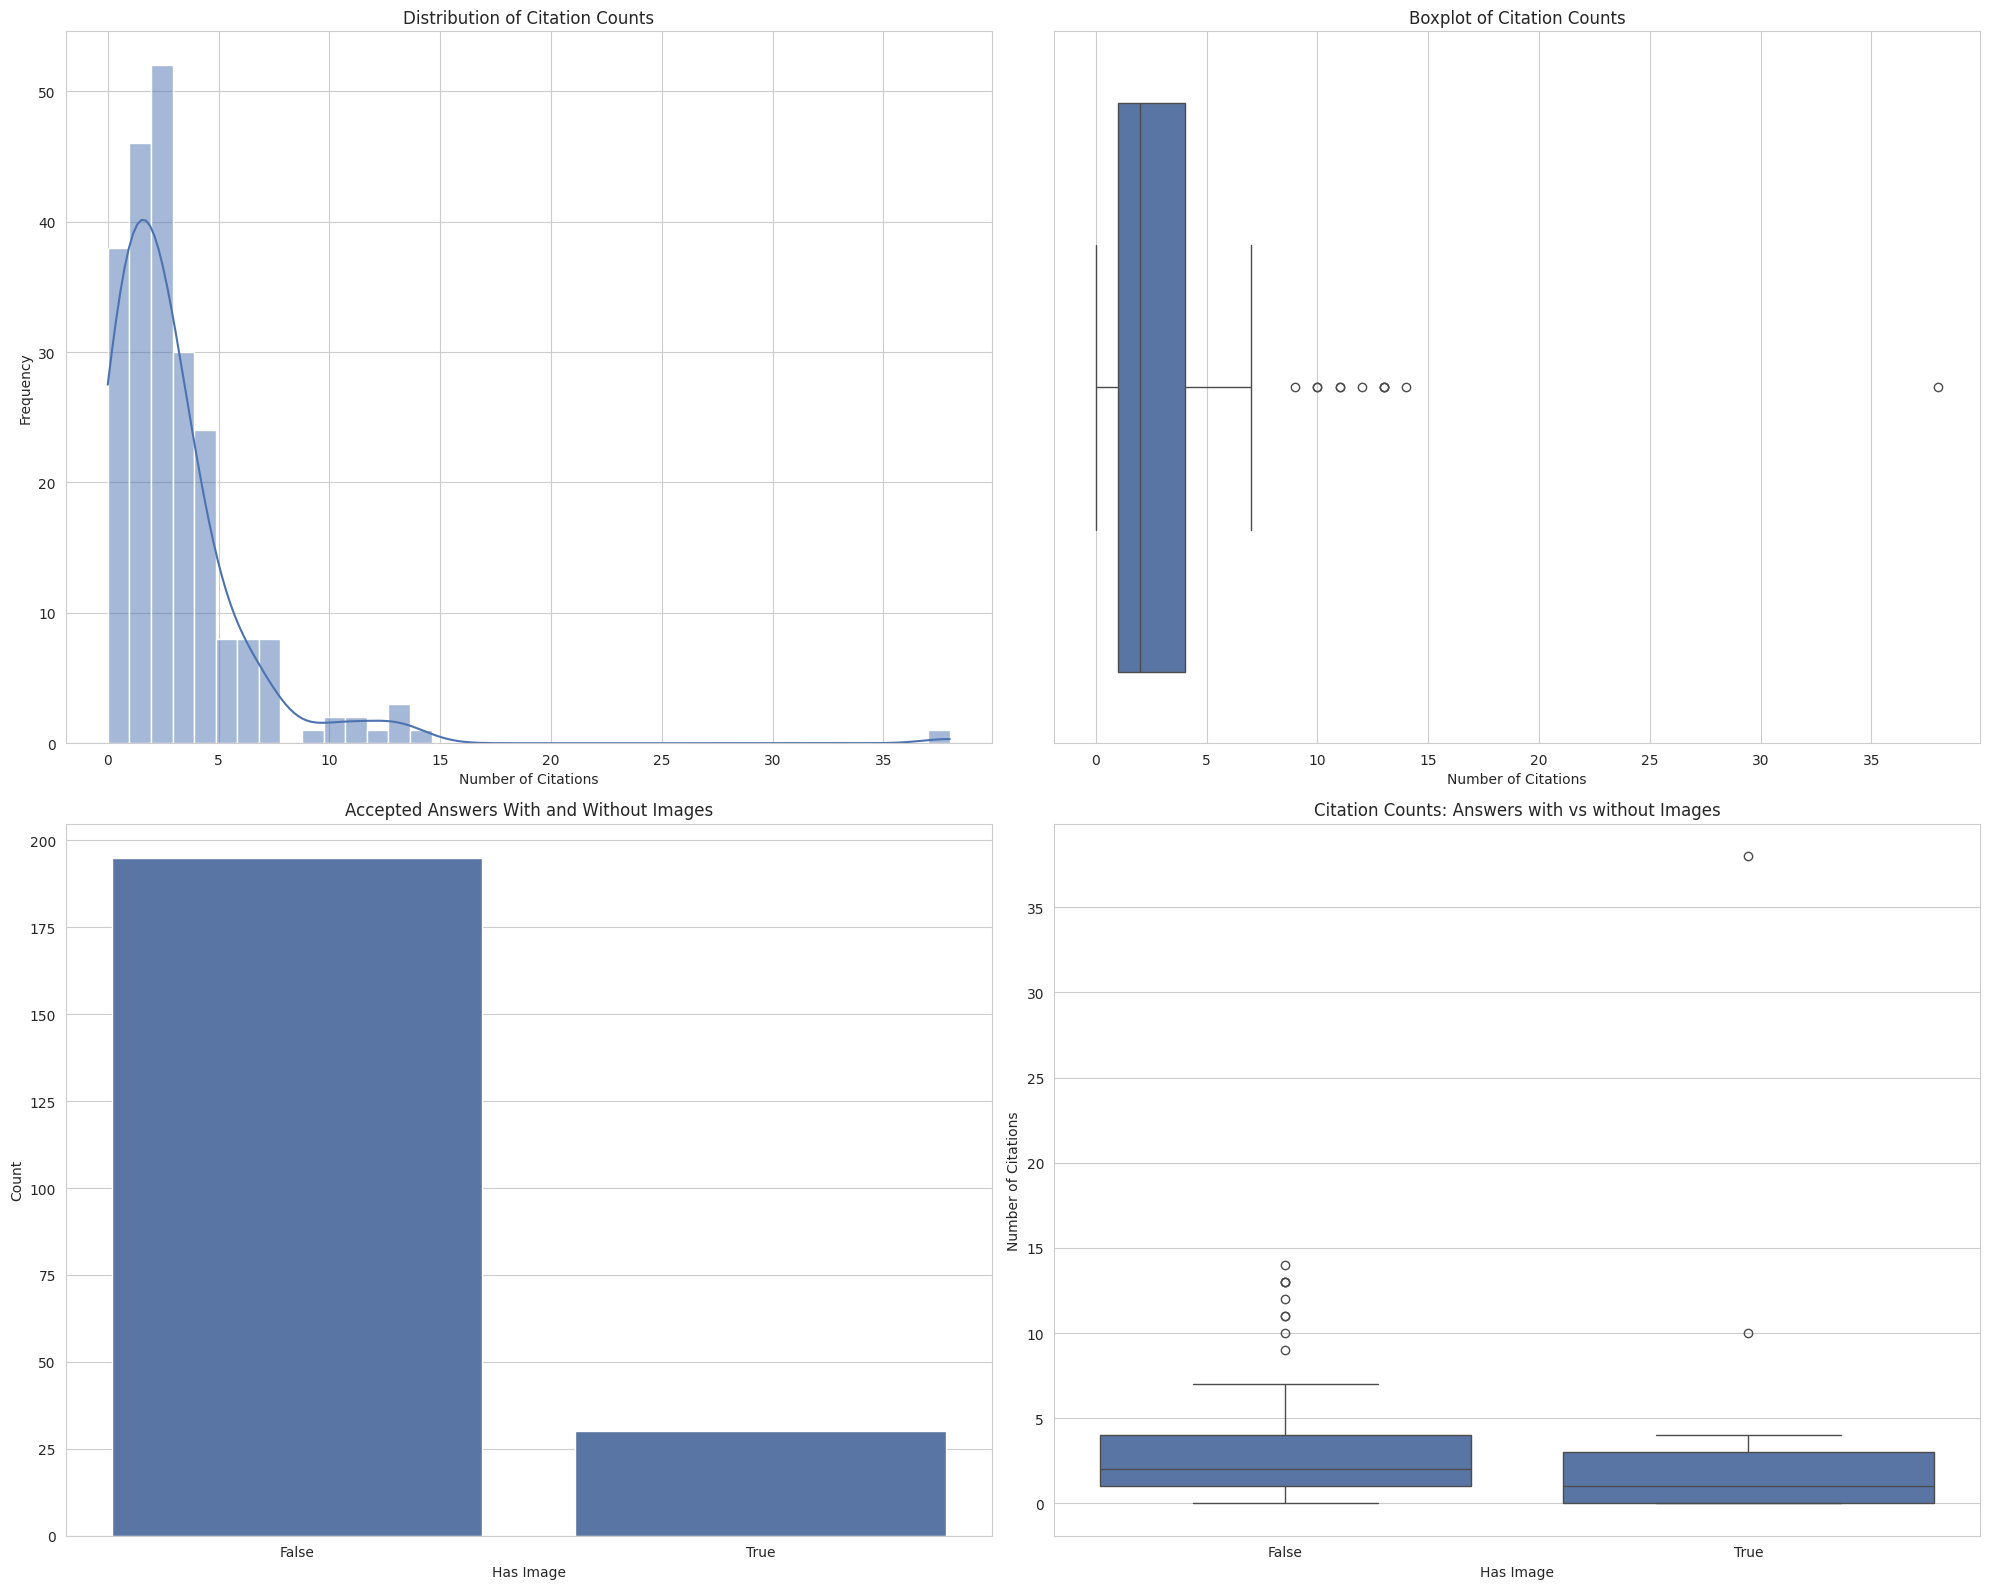

In [86]:
# Set the Seaborn style for consistent aesthetics
sns.set_style("whitegrid")
sns.set_palette("deep")

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# Plot 1: Distribution of citation counts
sns.histplot(data=df_merged, x='citations_count', kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Citation Counts')
axes[0, 0].set_xlabel('Number of Citations')
axes[0, 0].set_ylabel('Frequency')

# Plot 2: Boxplot of citation counts
sns.boxplot(data=df_merged, x='citations_count', ax=axes[0, 1])
axes[0, 1].set_title('Boxplot of Citation Counts')
axes[0, 1].set_xlabel('Number of Citations')

# Plot 3: Accepted Answers With and Without Images
sns.countplot(data=df_merged, x='has_image', ax=axes[1, 0])
axes[1, 0].set_title('Accepted Answers With and Without Images')
axes[1, 0].set_xlabel('Has Image')
axes[1, 0].set_ylabel('Count')

# Plot 4: Citation Counts for Answers with vs without Images
sns.boxplot(data=df_merged, x='has_image', y='citations_count', ax=axes[1, 1])
axes[1, 1].set_title('Citation Counts: Answers with vs without Images')
axes[1, 1].set_xlabel('Has Image')
axes[1, 1].set_ylabel('Number of Citations')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [87]:

# Print statistics
print(f"Total number of accepted answers: {len(df_merged)}")
print(f"Accepted answers with images: {df_merged['has_image'].sum()}")
print(f"Accepted answers without images: {len(df_merged) - df_merged['has_image'].sum()}")
print(f"\nAccepted answers with citations: {df_merged['has_citations'].sum()}")
print(f"Accepted answers without citations: {len(df_merged) - df_merged['has_citations'].sum()}")
print(f"\nMean number of citations: {df_merged['citations_count'].mean():.2f}")
print(f"Median number of citations: {df_merged['citations_count'].median():.2f}")

print("\nCitation count distribution:")
print(df_merged['citations_count'].value_counts().sort_index())

# Correlation between having an image and number of citations
correlation = df_merged['has_image'].corr(df_merged['citations_count'])
print(f"\nCorrelation between having an image and number of citations: {correlation:.4f}")

Total number of accepted answers: 225
Accepted answers with images: 30
Accepted answers without images: 195

Accepted answers with citations: 187
Accepted answers without citations: 38

Mean number of citations: 2.82
Median number of citations: 2.00

Citation count distribution:
citations_count
0     38
1     46
2     52
3     30
4     24
5      8
6      8
7      8
9      1
10     2
11     2
12     1
13     3
14     1
38     1
Name: count, dtype: int64

Correlation between having an image and number of citations: 0.0165


In [88]:
# Statistics on accepted answers with multiple images
answers_with_multiple_images = df_merged[df_merged['image_count'] > 1]
print(f"\nAccepted answers with multiple images: {len(answers_with_multiple_images)}")
print(f"Percentage of accepted answers with multiple images: {(len(answers_with_multiple_images) / len(df_merged)) * 100:.2f}%")

print("\nDistribution of image counts in accepted answers:")
print(df_merged['image_count'].value_counts().sort_index())

# Average citation count for accepted answers with different numbers of images
print("\nAverage citation count by number of images in accepted answers:")
print(df_merged.groupby('image_count')['citations_count'].mean().sort_index())

# Correlation between number of images and number of citations in accepted answers
image_citation_correlation = df_merged['image_count'].corr(df_merged['citations_count'])
print(f"\nCorrelation between number of images and number of citations in accepted answers: {image_citation_correlation:.4f}")


Accepted answers with multiple images: 10
Percentage of accepted answers with multiple images: 4.44%

Distribution of image counts in accepted answers:
image_count
0    195
1     20
2      7
3      3
Name: count, dtype: int64

Average citation count by number of images in accepted answers:
image_count
0    2.794872
1    3.550000
2    1.571429
3    2.333333
Name: citations_count, dtype: float64

Correlation between number of images and number of citations in accepted answers: -0.0165
